In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import scraping

In [2]:
# Get the data
# train, to_predict = scraping.run()
# For now, just use the data from the last run
train = pd.read_csv('lazada.csv')
to_predict = pd.read_csv('reviews.csv')

*I choose Lazada platform for this exercise.


After spending some time on the Lazada site, I realized that the "number of sold" metric represents the total sales since the product first became available, rather than a standardized measure like year-to-date (YTD) sales. Then, during my investigation, I identified a feature that tends to correlate with the number of units sold: the number of reviews. To analyze this further, I wrote a Python script to scrape data from the Lazada site for use in the analysis.

In [3]:
train.nlargest(5, 'num_sold')

,product,nmv,gmv,num_sold,num_reviews
2,ESQA Flawless Powder Foundation,99.00,135.0,7900.0,2175
0,ESQA Flawless Liquid Concealer,90.00,120.0,7200.0,2141
7,ESQA Flawless Liquid Mini Concealer,46.55,49.0,6300.0,2136
1,[New] ESQA Flawless Cushion Serum SPF 50+ PA++...,160.00,208.0,4400.0,1262
8,ESQA Flawless Setting Powder,99.00,135.0,2700.0,793


Here's the structure of the dataset

| Column        | Description                    |
|---------------|--------------------------------|
| product       | Name or description of product |
| nmv           | Net Merchandise Value (Shown as a slash price)         |
| gmv           | Gross Merchandise Value (Shown as a full price)       |
| num_sold      | Number of units sold           |
| num_reviews   | Number of reviews              |


Since the "number of sold" metric represents total sales from the time the product first became available, building a model where "number of reviews" is regressed onto "number of sold" would reflect cumulative sales over the entire period. To find a sales only on year-to-date (YTD), we need the "number of reviews" from the beginning of the year onward. Fortunately, this data can also be scraped from the Lazada site.


In [4]:
to_predict.head()

,name,review_dates,review_authors
0,ESQA Flawless Powder Foundation,12 jam lalu,8***7
1,ESQA Flawless Powder Foundation,3 hari lalu,Feni
2,ESQA Flawless Powder Foundation,1 minggu lalu,Reza A.
3,ESQA Flawless Powder Foundation,1 minggu lalu,I***.
4,ESQA Flawless Powder Foundation,1 minggu lalu,Bintang I.


The dataset construct of top selling 5 products on the store (based on # of unit sold) and their review_dates and review_authors

In [5]:
to_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            1750 non-null   object
 1   review_dates    1750 non-null   object
 2   review_authors  1750 non-null   object
dtypes: object(3)
memory usage: 41.1+ KB


In [6]:
# Convert this dataset to count the number of reviews ytd
ytd_reviews = to_predict.groupby('name')['review_dates'].count().reset_index()
ytd_reviews.columns = ['name', 'num_reviews_ytd']
ytd_reviews.head()

,name,num_reviews_ytd
0,ESQA Flawless Liquid Concealer,521
1,ESQA Flawless Liquid Mini Concealer,473
2,ESQA Flawless Powder Foundation,371
3,ESQA Flawless Setting Powder,111
4,[New] ESQA Flawless Cushion Serum SPF 50+ PA++...,274


Now, let's do some EDAs to uncover some insights.

In [7]:
%matplotlib inline

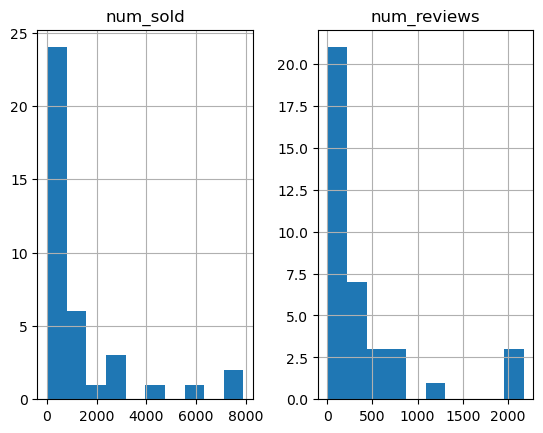

In [8]:
# Plot the number of reviews ytd
train[['num_sold', 'num_reviews']].hist();

In [9]:
# Very high correlation between the number of reviews and the number of items sold
train[['num_sold', 'num_reviews']].corr()

,num_sold,num_reviews
num_sold,1.000000,0.994831
num_reviews,0.994831,1.000000


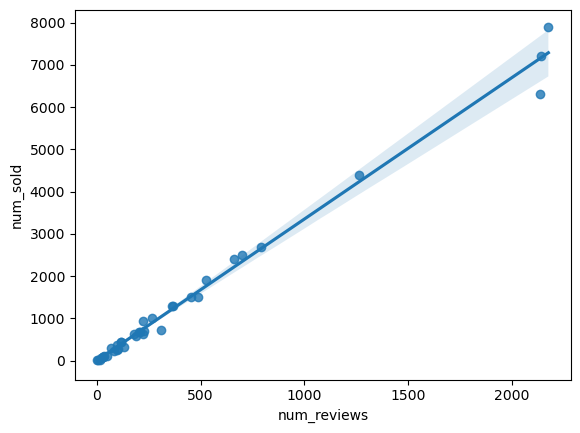

In [10]:
# Let's plot the relationship between the number of reviews and the number of items sold
sns.regplot(data=train, y='num_sold', x='num_reviews');

Let's discuss hypothesis for this model.
#### Hypothesis
1. A consistent fraction of buyers leave reviews, enabling the use of reviews as a reliable proxy for estimating sales.
2. Individuals who leave reviews may be influenced by self-selection bias. However, for the purposes of this analysis, we will treat these reviewers as representative of the overall population. This assumption relies on the idea that reviewers are uniformly and randomly distributed, potentially due to factors like incentives (e.g., Lazada offering reward coins for submitting a review).
3. From the graph, the relationship between reviews and sales is linear or can be approximated using regression analysis.
4. Year-to-date (YTD) sales can be estimated by isolating reviews from the beginning of the year and applying the established review-to-sale ratio.
5. As shown in the graph, there may be issues with heteroscedasticity (non-constant variability across the range) or high-leverage points (which are of particular interest). However, due to the limited data available in these high-value regions, we will, for the sake of simplicity, disregard these issues in this analysis.

#### Modeling: Linear regression

In [11]:
# First discard the low number of reviews, as they can be noisy
train = train[train['num_reviews'] > 10]

In [12]:
y = train['num_sold'].values
X = train['num_reviews'].values
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [13]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3179.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           3.58e-35
Time:                        23:22:36   Log-Likelihood:                -242.15
No. Observations:                  36   AIC:                             488.3
Df Residuals:                      34   BIC:                             491.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8287     42.636      0.137      0.8

Analysis
- R-squared: 0.989 =>
The model explains 98.9% of the variability in the dependent variable, indicating a very strong fit.
- Intercept (const): 5.8287 =>
This estimate is not statistically significant (p=.892), It can be confirmed with the regression line as It nearly pass the origin.
- x1: 3.3470 =>
This coefficient is highly significant (p<.001), with a 95% confidence interval of [3.177, 3.503].

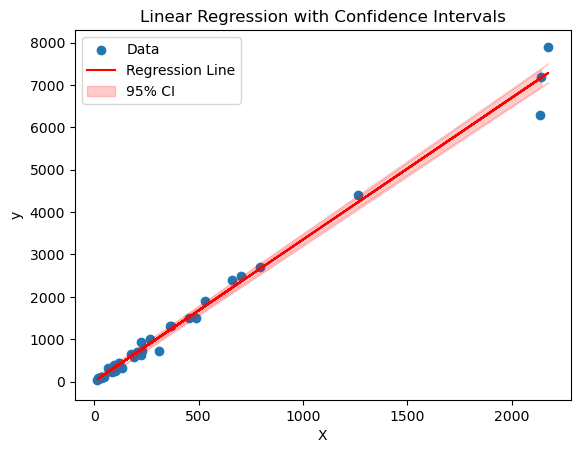

In [14]:
# Plot the ordinary least squares regression line
plt.scatter(X[:, 1], y, label="Data")
plt.plot(X[:, 1], model.predict(X), color='red', label="Regression Line")

# Add confidence intervals to the plot
pred = model.get_prediction(X)
ci = pred.conf_int(alpha=0.05)
plt.fill_between(X[:, 1], ci[:, 0], ci[:, 1], color='red', alpha=0.2, label="95% CI")

plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Linear Regression with Confidence Intervals")
plt.show()

As you can see, It may violate homoscedasticity.

#### Predicting 2024 YTD Sales for Best-Selling 5 Products

In [15]:
ytd_reviews.head()

,name,num_reviews_ytd
0,ESQA Flawless Liquid Concealer,521
1,ESQA Flawless Liquid Mini Concealer,473
2,ESQA Flawless Powder Foundation,371
3,ESQA Flawless Setting Powder,111
4,[New] ESQA Flawless Cushion Serum SPF 50+ PA++...,274


In [16]:
X_test = ytd_reviews['num_reviews_ytd'].values

In [17]:
X_test = sm.add_constant(X_test)
pred = model.predict(X_test)
prediction = model.get_prediction(X_test)

# Extract confidence intervals
confidence_intervals = prediction.conf_int()


In [18]:
print("Confidence Intervals:")
print(confidence_intervals)

Confidence Intervals:
[[1678.21325199 1821.00527996]
 [1518.32112466 1659.58659974]
 [1176.98271167 1318.13954668]
 [ 297.77239865  456.91631881]
 [ 850.41210948  995.39455862]]


In [19]:
ytd_reviews['unit'] = (confidence_intervals[:, 0] + confidence_intervals[:, 1]) / 2
ytd_reviews['lower_bound_unit'] = confidence_intervals[:, 0]
ytd_reviews['upper_bound_unit'] = confidence_intervals[:, 1]
ytd_reviews = ytd_reviews.merge(train[['product', 'gmv']], left_on='name', right_on='product', how='left').drop(columns=['product'])
ytd_reviews['sales'] = ytd_reviews['unit'] * ytd_reviews['gmv']
ytd_reviews['lower_bound_sales'] = ytd_reviews['lower_bound_unit'] * ytd_reviews['gmv']
ytd_reviews['upper_bound_sales'] = ytd_reviews['upper_bound_unit'] * ytd_reviews['gmv']
ytd_reviews['confidence_range (Q)'] = ytd_reviews['lower_bound_unit'].round(2).astype(str) + ' - ' + ytd_reviews['upper_bound_unit'].round(2).astype(str)
ytd_reviews['confidence_range (RP)'] = ytd_reviews['lower_bound_sales'].round(2).astype(str) + ' - ' + ytd_reviews['upper_bound_sales'].round(2).astype(str)

In [20]:
to_use = ytd_reviews[['name', 'num_reviews_ytd', 'unit', 'confidence_range (Q)', 'gmv', 'sales', 'confidence_range (RP)']]

In [21]:
to_use['unit'] = to_use['unit'].round(2)
to_use['sales'] = to_use['sales'].round(2)

/tmp/ipykernel_79580/4217947982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_use['unit'] = to_use['unit'].round(2)
/tmp/ipykernel_79580/4217947982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_use['sales'] = to_use['sales'].round(2)


In [22]:
to_use.columns = ['Product', 'Number of Reviews YTD', 'Units Sold', 'Confidence Range (Units)', 'Price Per Unit (Gross)(RP)', 
                  'Estimated Revenue YTD (RP)', 'Confidence Range (RP)']

In [23]:
to_use

,Product,Number of Reviews YTD,Units Sold,Confidence Range (Units),Price Per Unit (Gross)(RP),Estimated Revenue YTD (RP),Confidence Range (RP)
0,ESQA Flawless Liquid Concealer,521,1749.61,1678.21 - 1821.01,120.0,209953.11,201385.59 - 218520.63
1,ESQA Flawless Liquid Mini Concealer,473,1588.95,1518.32 - 1659.59,49.0,77858.74,74397.74 - 81319.74
2,ESQA Flawless Powder Foundation,371,1247.56,1176.98 - 1318.14,135.0,168420.75,158892.67 - 177948.84
3,ESQA Flawless Setting Powder,111,377.34,297.77 - 456.92,135.0,50941.49,40199.27 - 61683.7
4,[New] ESQA Flawless Cushion Serum SPF 50+ PA++...,274,922.90,850.41 - 995.39,208.0,191963.89,176885.72 - 207042.07


In [24]:
# Save the results to a csv file
to_use.to_csv('predictions_ytd_sales.csv', index=False)

#### Further Improvements
1. Consider finding another store within the same industry that shares a similar sales pattern to better estimate data in regions with high leverage points.
2. If we can scrape Lazada data beyond 200 pages, we could construct time-series features to capture patterns linked to specific dates, such as festivals (e.g., 9.9, 10.10). This would improve the use of dates as proxies for estimating sales more accurately.
3. Consider using "OLSResults.get_robustcov_results" to combat with heteroscedasticity.